In [29]:
from cleaning import database_cleaner

from pprint import pprint
import string
import re

# Gensim
import gensim
from gensim.models import CoherenceModel
from gensim import models, corpora
from gensim import similarities

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK
from nltk.corpus import stopwords
from nltk import word_tokenize

# spacy for lemmatization
import spacy

In [30]:
def get_data(filename):
    """Load raw data from a file and return vectorizer and feature_matrix.
    Parameters
    ----------
    filename: The path to a json file containing the university database.
    Returns
    -------
    corpus: A numpy array containing abstracts.
    """
    df_cleaned = database_cleaner(filename)

    # For nlp, only retaining faculty_name, research_areas, paper_titles, abstracts
    df_filtered = df_cleaned[['faculty_name', 'research_areas', 'paper_titles', 'abstracts']]
    missing = df_filtered['paper_titles'] == ''
    num_missing = sum(missing)
    print(f'{num_missing} faculties have missing papers in {filename}')
    print('Running nlp-pipeline on faculties with non-missing papers...')

    df_nlp = df_filtered[~missing]

    # Choosing abstracts and paper_titles to predict topics for a professor
    data = (df_nlp['paper_titles'] + df_nlp['abstracts']).values

    return data

data = get_data('../data/pge_database.json')

0 faculties have missing papers in ../data/pge_database.json
Running nlp-pipeline on faculties with non-missing papers...


In [31]:
data.shape

(88,)

In [32]:
# NLTK Stop words
stopwords_ = stopwords.words('english')

def clean_text(text):
    tokenized_text = word_tokenize(text.lower())
    cleaned_text = [t for t in tokenized_text if t not in stopwords_ and re.match('[a-zA-Z-][a-zA-Z-]{2,}', t)]
    return cleaned_text
 
# For gensim we need to tokenize the data and filter out stopwords
tokens_filtered = []
for text in data:
    tokens_filtered.append(clean_text(text))

# def filter_tokens(sent):
#     return([w for w in sent if not w in stopwords_ and not w in punctuation_ and re.match('[a-zA-Z-][a-zA-Z-]{2,}]', w)])

# tokens = [word_tokenize(doc) for doc in corpus]
# tokens_lower = [[word.lower() for word in sent] for sent in tokens]
# tokens_filtered = list(map(filter_tokens, tokens_lower))

In [33]:
# Build the bigram and trigram models
import warnings
warnings.filterwarnings("ignore",category=UserWarning)

bigram = gensim.models.Phrases(tokens_filtered, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokens_filtered], threshold=100) 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [34]:
# Form Bigrams
tokens_bigrams = make_bigrams(tokens_filtered)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(tokens_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [35]:
n_topics = 9

# Build a Dictionary - association word to numeric id
dictionary = corpora.Dictionary(tokens_filtered)

In [36]:
# Transform the collection of texts to a numerical form [(word_id, count), ...]
corpus = [dictionary.doc2bow(text) for text in tokens_filtered]

In [37]:
tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary) # tfidf gives better coherence score

lda_model = gensim.models.ldamodel.LdaModel(tfidf_model[corpus], id2word=dictionary, num_topics=n_topics)

# Build the LDA model
# lda_model = models.LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary)
 
# Build the LSI model
lsi_model = models.LsiModel(corpus=corpus, num_topics=n_topics, id2word=dictionary)

In [38]:
print("LDA Model:")
 
for idx in range(n_topics):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))
 
print("=" * 20)
 
print("LSI Model:")
 
for idx in range(n_topics):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lsi_model.print_topic(idx, 10))
 
print("=" * 20)

LDA Model:
Topic #0: 0.000*"fracture" + 0.000*"slug" + 0.000*"fts" + 0.000*"wax" + 0.000*"pga" + 0.000*"cement" + 0.000*"casing" + 0.000*"seismic" + 0.000*"pvs" + 0.000*"surfactants"
Topic #1: 0.000*"fracture" + 0.000*"acid" + 0.000*"toolkit" + 0.000*"height" + 0.000*"slug" + 0.000*"drillstring" + 0.000*"holdup" + 0.000*"lineaments" + 0.000*"bit" + 0.000*"foam"
Topic #2: 0.000*"basins" + 0.000*"uruguayan" + 0.000*"uruguay" + 0.000*"fiscal" + 0.000*"tgs" + 0.000*"restimulation" + 0.000*"hydrate" + 0.000*"fracture" + 0.000*"cfd" + 0.000*"edfm"
Topic #3: 0.000*"nanoparticles" + 0.000*"foam" + 0.000*"polymer" + 0.000*"fracture" + 0.000*"surfactant" + 0.000*"asp" + 0.000*"basins" + 0.000*"hydrate" + 0.000*"permeability" + 0.000*"recovery"
Topic #4: 0.000*"peridynamic" + 0.000*"acid" + 0.000*"matrix-vug" + 0.000*"phase-field" + 0.000*"peridynamics" + 0.000*"vuggy" + 0.000*"fracture" + 0.000*"bands" + 0.000*"organic-rich" + 0.000*"vugs"
Topic #5: 0.000*"upgridding" + 0.000*"geosteering" + 0.0

In [39]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens_filtered, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.0726241563

Coherence Score:  0.451594856694


In [40]:
# LDA Mallet (slower)
mallet_path = '~/Documents/GitHub/capstone/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=n_topics, id2word=dictionary, prefix='~/Documents/Github/capstone/')

In [41]:
# Show Topics
#pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=tokens_filtered, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.47033239013


# Choosing number of topics

In [42]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [43]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=tokens_filtered, start=5, limit=21, step=2)

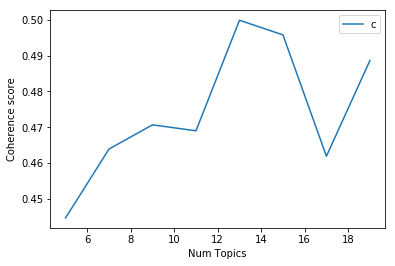

In [44]:
# Show graph
limit=21; start=5; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [45]:
# Print the coherence scores (9 seems to be optimal here)
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.4447
Num Topics = 7  has Coherence Value of 0.4639
Num Topics = 9  has Coherence Value of 0.4707
Num Topics = 11  has Coherence Value of 0.469
Num Topics = 13  has Coherence Value of 0.4999
Num Topics = 15  has Coherence Value of 0.4958
Num Topics = 17  has Coherence Value of 0.4619
Num Topics = 19  has Coherence Value of 0.4886


In [18]:
# Visualize the topics with simple lda model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      82.452324        1       1 -0.002621  0.001562
3       5.343538        1       2 -0.000368 -0.001114
5       3.855492        1       3  0.000644  0.000451
8       3.226458        1       4  0.002000  0.001988
4       1.719395        1       5  0.000506 -0.001370
2       1.241839        1       6  0.000188 -0.000636
0       1.158055        1       7 -0.000036 -0.000521
1       0.761086        1       8 -0.000504 -0.000405
6       0.241817        1       9  0.000189  0.000045, topic_info=      Category        Freq            Term       Total  loglift  logprob
term                                                                    
989    Default  128.000000        fracture  128.000000  30.0000  30.0000
5150   Default  121.000000      surfactant  121.000000  29.0000  29.0000
5695   Default  138.000000   nanoparticles  138.000000  28.0000  28.0000
5457   Default  100.000000            foam  100.000000  27.0000  27.0000
24     Default   98.000000            acid   98.000000  26.0000  26.0000
2326   Default   95.000000     surfactants   95.000000  25.0000  25.0000
722    Default   89.000000        drilling   89.000000  24.0000  24.0000
1719   Default  100.000000    permeability  100.000000  23.0000  23.0000
1759   Default   90.000000         polymer   90.000000  22.0000  22.0000
5453   Default   72.000000          floods   72.000000  21.0000  21.0000
304    Default  117.000000          cement  117.000000  20.0000  20.0000
2590   Default   79.000000        wellbore   79.000000  19.0000  19.0000
5461   Default  102.000000           foams  102.000000  18.0000  18.0000
8642   Default   64.000000             asp   64.000000  17.0000  17.0000
3462   Default   75.000000        recovery   75.000000  16.0000  16.0000
1029   Default   80.000000             gas   80.000000  15.0000  15.0000
5530   Default   70.000000         hydrate   70.000000  14.0000  14.0000
1615   Default   74.000000             oil   74.000000  13.0000  13.0000
4427   Default   85.000000             eor   85.000000  12.0000  12.0000
999    Default   74.000000       fractures   74.000000  11.0000  11.0000
5452   Default   76.000000        flooding   76.000000  10.0000  10.0000
2136   Default   70.000000           shale   70.000000   9.0000   9.0000
2002   Default   72.000000       reservoir   72.000000   8.0000   8.0000
9120   Default  149.000000          basins  149.000000   7.0000   7.0000
1156   Default   84.000000      imbibition   84.000000   6.0000   6.0000
280    Default   66.000000       carbonate   66.000000   5.0000   5.0000
4860   Default  110.000000         seismic  110.000000   4.0000   4.0000
2353   Default   72.000000     temperature   72.000000   3.0000   3.0000
1635   Default   65.000000    optimization   65.000000   2.0000   2.0000
434    Default   75.000000    conductivity   75.000000   1.0000   1.0000
...        ...         ...             ...         ...      ...      ...
18665   Topic9    0.112943    declustering   22.290319   0.7397  -9.4000
18688   Topic9    0.112943       sinuosity   22.290312   0.7397  -9.4000
18692   Topic9    0.112942   waxing–waning   22.290359   0.7397  -9.4000
18667   Topic9    0.112942     event-based   22.290400   0.7397  -9.4000
9557    Topic9    0.163666  connectivities   32.677139   0.7281  -9.0290
4963    Topic9    0.125388       turbidite   25.872313   0.6952  -9.2954
11300   Topic9    0.126773     confinement   26.235323   0.6923  -9.2845
16856   Topic9    0.115542    well-to-well   24.042568   0.6868  -9.3772
4716    Topic9    0.131594         objects   27.563168   0.6802  -9.2471
10153   Topic9    0.194602       eccentric   48.204575   0.5125  -8.8559
1926    Topic9    0.156241        reaction   36.178604   0.5799  -9.0755
5233    Topic9    0.140055          barite   31.868706   0.5974  -9.1848
2284    Topic9    0.159057      streamline   40.428230   0.4867  -9.0576
2872 

Text(0.5,1,'Coherence Plot for LDAMallet model')

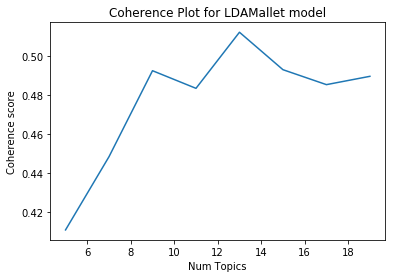

In [52]:
plt.plot(list_num_topics, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.title('Coherence Plot for LDA model')
plt.title('Coherence Plot for LDAMallet model')
# plt.show()

# Visualizing best lda_mallet model
* Code taken from: https://github.com/jerielizabeth/Gospel-of-Health-Notebooks/blob/master/blogPosts/pyLDAvis_and_Mallet.ipynb

In [19]:
import gzip
import os
import pandas as pd

dataDir = "/Users/Neha/Documents/GitHub/capstone"

def extract_params(statefile):
    """Extract the alpha and beta values from the statefile.

    Args:
        statefile (str): Path to statefile produced by MALLET.
    Returns:
        tuple: alpha (list), beta    
    """
    with gzip.open(statefile, 'r') as state:
        params = [x.decode('utf8').strip() for x in state.readlines()[1:3]]
    return (list(params[0].split(":")[1].split(" ")), float(params[1].split(":")[1]))


def state_to_df(statefile):
    """Transform state file into pandas dataframe.
    The MALLET statefile is tab-separated, and the first two rows contain the alpha and beta hypterparamters.
    
    Args:
        statefile (str): Path to statefile produced by MALLET.
    Returns:
        datframe: topic assignment for each token in each document of the model
    """
    return pd.read_csv(statefile,
                       compression='gzip',
                       sep=' ',
                       skiprows=[1,2]
                       )


In [20]:
params = extract_params(os.path.join(dataDir, 'state.mallet.gz'))

In [21]:
alpha = [float(x) for x in params[0][1:]]
beta = params[1]
print("{}, {}".format(alpha, beta))

[5.555555555555555, 5.555555555555555, 5.555555555555555, 5.555555555555555, 5.555555555555555, 5.555555555555555, 5.555555555555555, 5.555555555555555, 5.555555555555555], 0.01


In [22]:
df = state_to_df(os.path.join(dataDir, 'state.mallet.gz'))

In [23]:
df['type'] = df.type.astype(str)
df[:10]

,#doc,source,pos,typeindex,type,topic
0,0,NaN,0,0,-based,4
1,0,NaN,1,1,-scan,4
2,0,NaN,2,2,ability,4
3,0,NaN,3,2,ability,4
4,0,NaN,4,2,ability,4
5,0,NaN,5,3,absence,4
6,0,NaN,6,4,abstract,3
7,0,NaN,7,4,abstract,3
8,0,NaN,8,4,abstract,3
9,0,NaN,9,4,abstract,8


In [24]:
# Get document lengths from statefile
docs = df.groupby('#doc')['type'].count().reset_index(name ='doc_length')

docs[:10]

,#doc,doc_length
0,0,14767
1,1,6476
2,2,2975
3,3,9746
4,4,1732
5,5,10177
6,6,858
7,7,10449
8,8,7576
9,9,11286


In [25]:
# Get vocab and term frequencies from statefile
vocab = df['type'].value_counts().reset_index()
vocab.columns = ['type', 'term_freq']
vocab = vocab.sort_values(by='type', ascending=True)

vocab[:10]

,type,term_freq
18404,-acetamide,1
11750,-acetate-hpam,2
4669,-based,11
21575,-benzoic,1
18822,-both,1
8814,-buckling,3
19467,-cost-effective,1
20728,-cpmg,1
19802,-density,1
11074,-derived,2


In [26]:
#  Topic-term matrix from state file
# https://ldavis.cpsievert.me/reviews/reviews.html

import sklearn.preprocessing

def pivot_and_smooth(df, smooth_value, rows_variable, cols_variable, values_variable):
    """
    Turns the pandas dataframe into a data matrix.
    Args:
        df (dataframe): aggregated dataframe 
        smooth_value (float): value to add to the matrix to account for the priors
        rows_variable (str): name of dataframe column to use as the rows in the matrix
        cols_variable (str): name of dataframe column to use as the columns in the matrix
        values_variable(str): name of the dataframe column to use as the values in the matrix
    Returns:
        dataframe: pandas matrix that has been normalized on the rows.
    """
    matrix = df.pivot(index=rows_variable, columns=cols_variable, values=values_variable).fillna(value=0)
    matrix = matrix.values + smooth_value
    
    normed = sklearn.preprocessing.normalize(matrix, norm='l1', axis=1)
    
    return pd.DataFrame(normed)

In [27]:
phi_df = df.groupby(['topic', 'type'])['type'].count().reset_index(name ='token_count')
phi_df = phi_df.sort_values(by='type', ascending=True)

phi_df[:10]

,topic,type,token_count
29142,8,-acetamide,1
21523,6,-acetate-hpam,1
3978,1,-acetate-hpam,1
11756,3,-based,2
15696,4,-based,9
25736,7,-benzoic,1
7714,2,-both,1
0,0,-buckling,3
19005,5,-cost-effective,1
15697,4,-cpmg,1


In [28]:
phi = pivot_and_smooth(phi_df, beta, 'topic', 'type', 'token_count')

In [29]:
theta_df = df.groupby(['#doc', 'topic'])['topic'].count().reset_index(name ='topic_count')

theta_df[:10]

,#doc,topic,topic_count
0,0,0,313
1,0,1,97
2,0,2,52
3,0,3,4559
4,0,4,8350
5,0,5,483
6,0,6,412
7,0,7,42
8,0,8,459
9,1,0,1210


In [30]:
theta = pivot_and_smooth(theta_df, alpha , '#doc', 'topic', 'topic_count')

In [ ]:
import pyLDAvis

data = {'topic_term_dists': phi, 
        'doc_topic_dists': theta,
        'doc_lengths': list(docs['doc_length']),
        'vocab': list(vocab['type']),
        'term_frequency': list(vocab['term_freq'])
       }

In [32]:
vis_data = pyLDAvis.prepare(**data)

In [33]:
vis_data

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      16.085768        1       1 -0.055053 -0.018506
8      15.362212        1       2 -0.133555  0.082666
1      14.737749        1       3  0.053721 -0.077886
6      10.744847        1       4 -0.097688  0.266252
0      10.627940        1       5 -0.065378 -0.061269
4       9.759684        1       6  0.143786 -0.025703
2       8.042440        1       7  0.296846  0.076929
5       7.888397        1       8 -0.065301 -0.140213
7       6.750963        1       9 -0.077378 -0.102271, topic_info=      Category         Freq            Term        Total  loglift  logprob
term                                                                      
7463   Default  3775.000000        fracture  3775.000000  30.0000  30.0000
7106   Default  4726.000000            flow  4726.000000  29.0000  29.0000
5479   Default  1588.000000        drilling  1588.000000  28.0000  28.0000
7746   Default  4416.000000             gas  4416.000000  27.0000  27.0000
13615  Default  4286.000000             oil  4286.000000  26.0000  26.0000
10907  Default  1202.000000          liquid  1202.000000  25.0000  25.0000
185    Default  1114.000000            acid  1114.000000  24.0000  24.0000
7532   Default  1595.000000       fractures  1595.000000  23.0000  23.0000
16828  Default  3699.000000       reservoir  3699.000000  22.0000  22.0000
15436  Default  3512.000000        pressure  3512.000000  21.0000  21.0000
16469  Default  1769.000000        recovery  1769.000000  20.0000  20.0000
15658  Default  2927.000000      production  2927.000000  19.0000  19.0000
8930   Default  1108.000000       hydraulic  1108.000000  18.0000  18.0000
3516   Default   819.000000    conductivity   819.000000  17.0000  17.0000
19885  Default  1408.000000     temperature  1408.000000  16.0000  16.0000
20963  Default   953.000000  unconventional   953.000000  15.0000  15.0000
16871  Default  2358.000000      reservoirs  2358.000000  14.0000  14.0000
19553  Default   893.000000      surfactant   893.000000  13.0000  13.0000
17912  Default  2199.000000           shale  2199.000000  12.0000  12.0000
22063  Default  1196.000000        wellbore  1196.000000  11.0000  11.0000
6515   Default  1428.000000    experimental  1428.000000  10.0000  10.0000
4347   Default  2857.000000            data  2857.000000   9.0000   9.0000
7254   Default   903.000000            foam   903.000000   8.0000   8.0000
12207  Default  4851.000000           model  4851.000000   7.0000   7.0000
15060  Default  1118.000000            pore  1118.000000   6.0000   6.0000
17180  Default  1411.000000            rock  1411.000000   5.0000   5.0000
14797  Default   586.000000            pipe   586.000000   4.0000   4.0000
18369  Default   470.000000            slug   470.000000   3.0000   3.0000
14660  Default  1142.000000           phase  1142.000000   2.0000   2.0000
1631   Default  1253.000000        behavior  1253.000000   1.0000   1.0000
...        ...          ...             ...          ...      ...      ...
19885   Topic9   444.695856     temperature  1408.574834   1.5425  -4.3662
14660   Topic9   371.747388           phase  1142.896018   1.5724  -4.5454
1631    Topic9   374.745271        behavior  1253.307871   1.4882  -4.5373
16812   Topic9   158.897751        research   359.191906   1.8799  -5.3953
3479    Topic9    94.942930      condensate   175.748042   2.0797  -5.9103
15623   Topic9   297.799627         process  1176.019402   1.3220  -4.7672
1158    Topic9   107.933753      asphaltene   237.620235   1.9063  -5.7821
10715   Topic9    63.964814        learning    97.922713   2.2696  -6.3052
596     Topic9   134.914693       algorithm   419.373028   1.5614  -5.5589
16828   Topic9   403.724799       reservoir  3699.134099   0.4804  -4.4628
15436   Topic9   351.761507        pressure  3512.533821   0.3943  -4.6006
12633   Topic9   121.923870      multiphase   378.757186   1.56

In [61]:
from gensim_model import *
with open('../data/pge_gensim_LDA.pkl', 'rb') as f:
        gensim_LDA = pickle.load(f)

with open('../data/pge_gensim_LDAMallet.pkl', 'rb') as f:
        gensim_LDAMallet = pickle.load(f)

In [55]:
search_text = 'Gas from shale reservoirs is difficult to produce, unless they are effectively stimulated. Production from wells completed in these quad-porosity reservoirs is dependent on the placement of hydraulic fractures and their degree of connectivity to the existing natural fractures. These propped fractures and their effectiveness is a direct function of the in situ stress in the formation. Furthermore, geochemical diagenesis in the created fractures significantly impacts fracture conductivity. This paper utilizes a fracture-completed horizontal well in different configurations of quad-porosity shale gas reservoir models to assess the effect of gas flow and storage in these systems on production parameters. Furthermore, sensitivity analysis is carried out on critical parameters to observe its impact on well performance.'
gensim_LDA.transform_new(search_text)

[(0, 0.17410345), (1, 0.51784825), (3, 0.11274455), (5, 0.18887903)]

In [60]:
# Visualize the topics with simple lda model
pyLDAvis.enable_notebook()
gensim_LDA_vis = gensim_LDA.visualize_lda_model()
gensim_LDA_vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      35.205830        1       1  0.007583 -0.002146
4      20.062294        1       2 -0.002493 -0.001325
1      14.074673        1       3 -0.003746 -0.003057
3      12.812346        1       4 -0.000738 -0.004749
0      10.482350        1       5 -0.004670  0.003568
6       5.504786        1       6  0.001744  0.005572
2       1.857715        1       7  0.002320  0.002137, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
1507  Default  4782.000000         model  4782.000000  30.0000  30.0000
946   Default  4681.000000          flow  4681.000000  29.0000  29.0000
2002  Default  3640.000000     reservoir  3640.000000  28.0000  28.0000
1615  Default  4042.000000           oil  4042.000000  27.0000  27.0000
989   Default  3869.000000      fracture  3869.000000  26.0000  26.0000
562   Default  2699.000000          data  2699.000000  25.0000  25.0000
2585  Default  3069.000000          well  3069.000000  24.0000  24.0000
1029  Default  4591.000000           gas  4591.000000  23.0000  23.0000
2511  Default  2763.000000         using  2763.000000  22.0000  22.0000
1812  Default  3612.000000      pressure  3612.000000  21.0000  21.0000
953   Default  2173.000000         fluid  2173.000000  20.0000  20.0000
1469  Default  2049.000000        method  2049.000000  19.0000  19.0000
1719  Default  1909.000000  permeability  1909.000000  18.0000  18.0000
1836  Default  2957.000000    production  2957.000000  17.0000  17.0000
2508  Default  2530.000000          used  2530.000000  16.0000  16.0000
2136  Default  2086.000000         shale  2086.000000  15.0000  15.0000
2027  Default  2786.000000       results  2786.000000  14.0000  14.0000
917   Default  1597.000000         field  1597.000000  13.0000  13.0000
2041  Default  1245.000000          rock  1245.000000  12.0000  12.0000
2298  Default  2044.000000         study  2044.000000  11.0000  11.0000
2596  Default  1731.000000         wells  1731.000000  10.0000  10.0000
3462  Default  1610.000000      recovery  1610.000000   9.0000   9.0000
1227  Default  1465.000000     injection  1465.000000   8.0000   8.0000
722   Default  1672.000000      drilling  1672.000000   7.0000   7.0000
2004  Default  2372.000000    reservoirs  2372.000000   6.0000   6.0000
1510  Default  1974.000000        models  1974.000000   5.0000   5.0000
2570  Default  1897.000000         water  1897.000000   4.0000   4.0000
1858  Default  1324.000000    properties  1324.000000   3.0000   3.0000
107   Default  1705.000000      analysis  1705.000000   2.0000   2.0000
2353  Default  1283.000000   temperature  1283.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
1227   Topic7    31.793320     injection  1465.439209   0.1552  -5.7988
1130   Topic7    24.599106    horizontal  1100.782104   0.1848  -6.0553
989    Topic7    73.262985      fracture  3869.225342   0.0191  -4.9640
946    Topic7    86.193077          flow  4681.874512  -0.0090  -4.8014
2394   Topic7    26.773666          time  1217.266602   0.1689  -5.9706
2507   Topic7    24.359695           use  1106.544067   0.1698  -6.0651
2585   Topic7    57.905792          well  3069.818115   0.0153  -5.1992
1719   Topic7    38.239590  permeability  1909.172119   0.0753  -5.6141
2287   Topic7    20.825609        stress   936.840820   0.1795  -6.2218
1507   Topic7    80.747055         model  4782.157715  -0.0955  -4.8667
1913   Topic7    25.822947          rate  1226.619385   0.1251  -6.0068
2353   Topic7    26.636784   temperature  1283.944214   0.1104  -5.9757
2612   Topic7    22.269682          work  1033.744019   0.1481  -6.1548
1615   Topic7    64.974625           oil  4042.779785  -0.1449  -5.0840
2508   Topic7    44.883709          used  2530.462402  -0.0463  -5.4539
1836   Topic7  

In [67]:
gensim_LDAMallet_vis = gensim_LDAMallet.visualize_lda_mallet()
gensim_LDAMallet_vis

AttributeError: 'dict' object has no attribute 'num_topics'

# Dominant Topic for each professor

In [34]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    return(sent_topics_df)

In [35]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,0,4.0,0.5749,"acid, conductivity, rock, measurements, temper..."
1,1,7.0,0.4013,"temperature, reservoir, behavior, phase, press..."
2,2,2.0,0.5202,"oil, pore, gas, energy, combustion, samples, s..."
3,3,8.0,0.7442,"model, reservoir, flow, simulation, models, me..."
4,4,6.0,0.2762,"gas, production, data, unconventional, reservo..."
5,5,1.0,0.3792,"oil, recovery, water, surfactant, reservoir, i..."
6,6,5.0,0.2939,"flow, liquid, gas, model, pressure, experiment..."
7,7,2.0,0.5602,"oil, pore, gas, energy, combustion, samples, s..."
8,8,4.0,0.4828,"acid, conductivity, rock, measurements, temper..."
9,9,5.0,0.9106,"flow, liquid, gas, model, pressure, experiment..."


In [15]:
import numpy as np  
pge_df = database_cleaner('../data/pge_database.json')
pge_df.head()

,faculty_name,email,google_scholar_link,office,page,phone,faculty_title,paper_titles,abstracts,research_areas
0,A. Daniel Hill,danhill@tamu.edu,https://scholar.google.com/citations?user=EBnW...,RICH 1012,https://engineering.tamu.edu/petroleum/profile...,979-845-2244,Professor,Mechanism of wormholing and its optimal condi...,Acid stimulation is commonly used in carbonat...,Dr. Hill has five patents in oil recovery and ...
1,A. Rashid Hasan,rhasan@tamu.edu,https://scholar.google.com/citations?user=6lMX...,RICH 501E,https://engineering.tamu.edu/petroleum/profile...,979.847.8564,Professor,Probing rate estimation methods for multiphas...,Choke is an essential device that controls fl...,Wellbore Heat transferSystematic modeling of h...
2,Adam Brandt,abrandt@stanford.edu,https://scholar.google.com/citations?user=QF3U...,066 Green Earth Sciences Building,https://pangea.stanford.edu/people/adam-brandt,(650) 724-8251,Assistant Professor of Energy Resources Engine...,Optimal design and operation of integrated so...,Direct integration of solar thermal and natur...,G r e e n h o u s e g a s e m i s s i o n ...
3,Akhil Datta-Gupta,datta-gupta@tamu.edu,https://scholar.google.com/citations?user=Al-S...,RICH 401G,https://engineering.tamu.edu/petroleum/profile...,979-847-9030,University Distinguished Professor,Radius of Investigation and its Generalizatio...,The concept of radius of investigation is fun...,Dr. Datta-Gupta has research interests in rapi...
4,Albertus Retnanto,albertus.retnanto@qatar.tamu.edu,https://scholar.google.com/citations?user=kN7P...,204K,https://engineering.tamu.edu/petroleum/profile...,974-4423-0281,Associate Professor of the Practice,After-Closure Idiosyncrasies of Fracture C...,"Fracture Calibration Tests (FCT), are stra...",Field development and planning Production enha...


In [39]:
pge_df.index = list(range(88))
pge_df.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87],
           dtype='int64')

In [40]:
pd.concat([pge_df, df_dominant_topic], axis=1)

,faculty_name,email,google_scholar_link,office,page,phone,faculty_title,paper_titles,abstracts,research_areas,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,A. Daniel Hill,danhill@tamu.edu,https://scholar.google.com/citations?user=EBnW...,RICH 1012,https://engineering.tamu.edu/petroleum/profile...,979-845-2244,Professor,Mechanism of wormholing and its optimal condi...,Acid stimulation is commonly used in carbonat...,Dr. Hill has five patents in oil recovery and ...,0,4.0,0.5749,"acid, conductivity, rock, measurements, temper..."
1,A. Rashid Hasan,rhasan@tamu.edu,https://scholar.google.com/citations?user=6lMX...,RICH 501E,https://engineering.tamu.edu/petroleum/profile...,979.847.8564,Professor,Probing rate estimation methods for multiphas...,Choke is an essential device that controls fl...,Wellbore Heat transferSystematic modeling of h...,1,7.0,0.4013,"temperature, reservoir, behavior, phase, press..."
2,Adam Brandt,abrandt@stanford.edu,https://scholar.google.com/citations?user=QF3U...,066 Green Earth Sciences Building,https://pangea.stanford.edu/people/adam-brandt,(650) 724-8251,Assistant Professor of Energy Resources Engine...,Optimal design and operation of integrated so...,Direct integration of solar thermal and natur...,G r e e n h o u s e g a s e m i s s i o n ...,2,2.0,0.5202,"oil, pore, gas, energy, combustion, samples, s..."
3,Akhil Datta-Gupta,datta-gupta@tamu.edu,https://scholar.google.com/citations?user=Al-S...,RICH 401G,https://engineering.tamu.edu/petroleum/profile...,979-847-9030,University Distinguished Professor,Radius of Investigation and its Generalizatio...,The concept of radius of investigation is fun...,Dr. Datta-Gupta has research interests in rapi...,3,8.0,0.7442,"model, reservoir, flow, simulation, models, me..."
4,Albertus Retnanto,albertus.retnanto@qatar.tamu.edu,https://scholar.google.com/citations?user=kN7P...,204K,https://engineering.tamu.edu/petroleum/profile...,974-4423-0281,Associate Professor of the Practice,After-Closure Idiosyncrasies of Fracture C...,"Fracture Calibration Tests (FCT), are stra...",Field development and planning Production enha...,4,6.0,0.2762,"gas, production, data, unconventional, reservo..."
5,Anthony Kovscek,kovscek@stanford.edu,https://scholar.google.com/citations?user=CQ1k...,Department of Energy Resources Engineering,https://pangea.stanford.edu/people/anthony-kov...,(650) 723-1218,Keleen and Carlton Beal Professor in Energy Re...,An optimization algorithm for evaluation of k...,The design of enhanced oil recovery processes...,I a m i n t e r e s t e d i n t h e ...,5,1.0,0.3792,"oil, recovery, water, surfactant, reservoir, i..."
6,Aziz Rahman,aziz.rahman@qatar.tamu.edu,https://scholar.google.com/citations?user=PYRt...,204E,https://engineering.tamu.edu/petroleum/profile...,974-4423-0601,Assistant Professor,A comprehensive study on multiphase flow thro...,The reservoir productivity index depends on...,Flow assurance Multiphase pipe flow Wellbore h...,6,5.0,0.2939,"flow, liquid, gas, model, pressure, experiment..."
7,Berna Hascakir,hascakir@tamu.edu,https://scholar.google.com/citations?user=wdJY...,RICH 401N,https://engineering.tamu.edu/petroleum/profile...,979-845-6614,Assistant Professor,Water and aromatics fraction interaction at e...,Performance predictions of the In-Situ Combus...,Heavy oil and oil shale recovery with enhanced...,7,2.0,0.5602,"oil, pore, gas, energy, combustion, samples, s..."
8,Carlos Torres-Verdin,cverdin@austin.utexas.edu,https://scholar.google.com/citations?user=I-J9...,CPE 5.182A,https://www.pge.utexas.edu/facultystaff/profil...,"(512) 471-4216, (512) 471-3161",Professor,INTERPRETATION OF BOREHOLE SONIC MEASUREMENTS...,Clastic rocks with variable grain sizes exhi...,Static and Dynamic Formation Evaluation Boreho...,8,4.0,0.4828,"acid, conductivity, rock, measurements, temper..."
9,Cem Sarica,cem-sarica@utulsa.edu,https://scholar.google.com/citations?user=er_5...,,https://faculty.utulsa.edu/~/cem-sarica,918-631-5154,"F.H. ""Mick"" Merel

# Querying

In [ ]:
text = "Steam injection is a widely used oil-recovery method that has been commercially successful in many types of heavy-oil reservoirs, including the oil sands of Alberta, Canada. Steam is very effective in delivering heat that is the key to heavy-oil mobilization. In the distant past in California, and also recently in Alberta, solvents were/are being used as additives to steam for additional viscosity reduction. The current applications are in field projects involving steam-assisted gravity drainage (SAGD) and cyclic steam stimulation (CSS).The past and present projects using solvents alone or in combination with steam are reviewed and evaluated, including enhanced solvent SAGD (ES-SAGD) and liquid addition to steam for enhancing recovery (LASER). The use of solvent in other processes, such as effective solvent extraction incorporating electromagnetic heating (ESEIEH) and after cold-heavy-oil production with sand (CHOPS), are also reviewed. The theories behind the use of solvents with steam are outlined. These postulate additional heavy-oil/bitumen mobilization; oil mobilization ahead of the steam front; and oil mobilization by solvent dispersion caused by frontal instability. The plausibility of the different approaches and solvent availability and economics are also discussed."
bow = dictionary.doc2bow(clean_text(text))

print(lda_model[tfidf_model[bow]])
print(ldamallet[bow])

In [ ]:
# lda_index = similarities.MatrixSimilarity(lda_model[tfidf_model[corpus]])
lda_index = similarities.MatrixSimilarity(ldamallet[corpus])

In [ ]:
# Let's perform some queries
similarity_results = lda_index[lda_model[bow]]
# similarity_results = lda_index[lda_model[tfidf_model[bow]]]

# Sort the similarities
similarity_results = sorted(enumerate(similarity_results), key=lambda item: -item[1])
 
# Top most similar documents:
print(similarity_results[:10])

In [ ]:
# # Let's see what's the most similar document
# document_id, similarity = similarities[0]
# print(corpus[document_id][:1000])
# similarity_results = similarity_results[similarity_results[:,0].argsort()] # sorting by document_id
# document_ids = list(map(int, similarity_results[:,0]))

document_ids, similarity = list(zip(*similarity_results[:10]))
document_ids = list(map(str, document_ids))
document_ids

In [ ]:
pge_df

In [ ]:
results_df = pge_df[pge_df.index.isin(document_ids)].sort_index()
results_df['similarity'] = similarity
results_df.sort_values(by='similarity', ascending=False)[['faculty_name', 'research_areas', 'similarity']][:10]

In [1]:
from topic_model import MyTopicModel
from app import _get_model_results

In [3]:
search_text = 'Gas from shale reservoirs is difficult to produce, unless they are effectively stimulated. Production from wells completed in these quad-porosity reservoirs is dependent on the placement of hydraulic fractures and their degree of connectivity to the existing natural fractures. These propped fractures and their effectiveness is a direct function of the in situ stress in the formation. Furthermore, geochemical diagenesis in the created fractures significantly impacts fracture conductivity. This paper utilizes a fracture-completed horizontal well in different configurations of quad-porosity shale gas reservoir models to assess the effect of gas flow and storage in these systems on production parameters. Furthermore, sensitivity analysis is carried out on critical parameters to observe its impact on well performance.'
display_data = _get_model_results(search_text)
display_data

,faculty_name,faculty_title,research_areas,predicted_research_areas,office,email,phone,page,google_scholar_link
31,Jeff Spath,Professor,Analytical simulation and pressure transient t...,"[pore, permeability, imbibition, foam, capilla...",RICH 507,spath@tamu.edu,979-845-2278,https://engineering.tamu.edu/petroleum/profile...,
86,Yuefeng Sun,Professor,Quantitative petroleum geology: characterizati...,"[pore, permeability, imbibition, foam, capilla...",HALB 63,sun@tamu.edu,979-845-0635,https://engineering.tamu.edu/petroleum/profile...,
57,Mohamed Fadlelmula,Instructional Assistant Professor,Reservoir characterization Geostatistics Uncer...,"[fracture, fractures, hydraulic, stress, fract...",204F,mohamed.fadlelmula@qatar.tamu.edu,974-4423-0438,https://engineering.tamu.edu/petroleum/profile...,https://scholar.google.com/citations?user=IK60...
64,Nimir Elbashir,Professor,Dr. Elbashir is the Director of Texas A&M Engi...,"[combustion, steam, sagd, solvent, isc, bitume...",204F,nimir.elbashir@qatar.tamu.edu,974-4423-0128,https://engineering.tamu.edu/petroleum/profile...,https://scholar.google.com/citations?user=mO2O...
46,M. Sam Mannan,Regents Professor,Abnormal situation management Aerosol research...,"[basins, unconventional, resources, reserves, ...",CHEN 246,mannan@tamu.edu,979-862-3985,https://engineering.tamu.edu/petroleum/profile...,https://scholar.google.com/citations?user=omMK...


In [8]:
display_data.to_json()

'{"faculty_name":{"31":"Jeff Spath","86":"Yuefeng Sun","57":"Mohamed Fadlelmula","64":"Nimir Elbashir","35":"John Foster"},"faculty_title":{"31":"Professor","86":"Professor","57":"Instructional Assistant Professor","64":"Professor","35":"Associate Professor"},"research_areas":{"31":"Analytical simulation and pressure transient techniques.","86":"Quantitative petroleum geology: characterization of ultra-deep petroleum systems Rock physics: petrophysics and well log analysis poroelasticity, mechanics and electrodynamics of multiphase fractured porous media biogeophysics Reservoir geophysics: Core-log-seismic-electromagnetic integration for reservoir description \\u2013 Deep\\/frontier exploration, enhanced oil\\/gas recovery, carbon sequestration, and unconventional resources","57":"Reservoir characterization Geostatistics Uncertainty analysis Reliability based modeling Rock mechanics","64":"Dr. Elbashir is the Director of Texas A&M Engineering Experiment Station Gas and Fuels Research C

In [9]:
import pandas as pd
final_topic_df = pd.read_json('../data/final_topic_database.json')
final_topic_df.head()

,abstracts,email,faculty_name,faculty_title,google_scholar_link,office,page,paper_titles,phone,predicted_research_areas,predicted_topic_num,research_areas
0,Acid stimulation is commonly used in carbonat...,danhill@tamu.edu,A. Daniel Hill,Professor,https://scholar.google.com/citations?user=EBnW...,RICH 1012,https://engineering.tamu.edu/petroleum/profile...,Mechanism of wormholing and its optimal condi...,979-845-2244,"[acid, conductivity, acidizing, stimulation, f...",8,Dr. Hill has five patents in oil recovery and ...
1,Choke is an essential device that controls fl...,rhasan@tamu.edu,A. Rashid Hasan,Professor,https://scholar.google.com/citations?user=6lMX...,RICH 501E,https://engineering.tamu.edu/petroleum/profile...,Probing rate estimation methods for multiphas...,979.847.8564,"[drilling, wellbore, cement, mud, bit, pipe, f...",2,Wellbore Heat transferSystematic modeling of h...
10,Langevin equations describe systems driven by...,tartakovsky@stanford.edu,Daniel Tartakovsky,Professor of Energy Resources Engineering,https://scholar.google.com/citations?user=4MdC...,367 Panama Street,https://pangea.stanford.edu/people/daniel-tart...,Nonlocal PDF methods for Langevin equations w...,(650) 498-8791,"[multiscale, hybrid, nonlinear, implicit, poro...",9,E n v i r o n m e n t a l f l u i d m e c ...
11,This paper presents an alternative method of ...,dicarlo@mail.utexas.edu,David DiCarlo,Associate Professor,https://scholar.google.com/citations?user=OFIv...,CPE 4.174,https://www.pge.utexas.edu/facultystaff/profil...,Replicating carbonaceous vug in synthetic por...,(512) 471-1283,"[pore, permeability, imbibition, foam, capilla...",11,Chemical EOR Gas Enhanced Oil Recovery Geologi...
12,Laboratory experiments of gas injection in or...,david-s-schechter@tamu.edu,David Schechter,Associate Professor,https://scholar.google.com/citations?user=QO_0...,RICH 610,https://engineering.tamu.edu/petroleum/profile...,Gas Injection for EOR in Organic Rich Shales....,979-845-2275,"[surfactant, recovery, polymer, surfactants, f...",1,Spraberry Trend Area Geological and petrophysi...


In [28]:
gensim_df = pd.read_json('../data/final_gensim_database.json')
gensim_df.sort_index()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,abstracts,email,faculty_name,faculty_title,google_scholar_link,office,page,paper_titles,phone,research_areas
0,0,0.0769,"ple, plagued, principally, pressure-normalized...",Acid stimulation is commonly used in carbonat...,danhill@tamu.edu,A. Daniel Hill,Professor,https://scholar.google.com/citations?user=EBnW...,RICH 1012,https://engineering.tamu.edu/petroleum/profile...,Mechanism of wormholing and its optimal condi...,979-845-2244,Dr. Hill has five patents in oil recovery and ...
1,0,0.0769,"ple, plagued, principally, pressure-normalized...",Choke is an essential device that controls fl...,rhasan@tamu.edu,A. Rashid Hasan,Professor,https://scholar.google.com/citations?user=6lMX...,RICH 501E,https://engineering.tamu.edu/petroleum/profile...,Probing rate estimation methods for multiphas...,979.847.8564,Wellbore Heat transferSystematic modeling of h...
2,0,0.0769,"ple, plagued, principally, pressure-normalized...",Direct integration of solar thermal and natur...,abrandt@stanford.edu,Adam Brandt,Assistant Professor of Energy Resources Engine...,https://scholar.google.com/citations?user=QF3U...,066 Green Earth Sciences Building,https://pangea.stanford.edu/people/adam-brandt,Optimal design and operation of integrated so...,(650) 724-8251,G r e e n h o u s e g a s e m i s s i o n ...
3,0,0.0769,"ple, plagued, principally, pressure-normalized...",The concept of radius of investigation is fun...,datta-gupta@tamu.edu,Akhil Datta-Gupta,University Distinguished Professor,https://scholar.google.com/citations?user=Al-S...,RICH 401G,https://engineering.tamu.edu/petroleum/profile...,Radius of Investigation and its Generalizatio...,979-847-9030,Dr. Datta-Gupta has research interests in rapi...
4,0,0.0769,"ple, plagued, principally, pressure-normalized...","Fracture Calibration Tests (FCT), are stra...",albertus.retnanto@qatar.tamu.edu,Albertus Retnanto,Associate Professor of the Practice,https://scholar.google.com/citations?user=kN7P...,204K,https://engineering.tamu.edu/petroleum/profile...,After-Closure Idiosyncrasies of Fracture C...,974-4423-0281,Field development and planning Production enha...
5,0,0.0769,"ple, plagued, principally, pressure-normalized...",The design of enhanced oil recovery processes...,kovscek@stanford.edu,Anthony Kovscek,Keleen and Carlton Beal Professor in Energy Re...,https://scholar.google.com/citations?user=CQ1k...,Department of Energy Resources Engineering,https://pangea.stanford.edu/people/anthony-kov...,An optimization algorithm for evaluation of k...,(650) 723-1218,I a m i n t e r e s t e d i n t h e ...
6,0,0.0769,"ple, plagued, principally, pressure-normalized...",The reservoir productivity index depends on...,aziz.rahman@qatar.tamu.edu,Aziz Rahman,Assistant Professor,https://scholar.google.com/citations?user=PYRt...,204E,https://engineering.tamu.edu/petroleum/profile...,A comprehensive study on multiphase flow thro...,974-4423-0601,Flow assurance Multiphase pipe flow Wellbore h...
7,0,0.0769,"ple, plagued, principally, pressure-normalized...",Performance predictions of the In-Situ Combus...,hascakir@tamu.edu,Berna Hascakir,Assistant Professor,https://scholar.google.com/citations?user=wdJY...,RICH 401N,https://engineering.tamu.edu/petroleum/profile...,Water and aromatics fraction interaction at e...,979-845-6614,Heavy oil and oil shale recovery with enhanced...
8,0,0.0769,"ple, plagued, principally, pressure-normalized...",Clastic rocks with variable grain sizes exhi...,cverdin@austin.utexas.edu,Carlos Torres-Verdin,Professor,https://scholar.google.com/citations?user=I-J9...,CPE 5.182A,https://www.pge.utexas.edu/facultystaff/profil...,INTERPRETATION OF BOREHOLE SONIC MEASUREMENTS...,"(512) 471-4216, (512) 471-3161",Static and Dynamic Formation Evaluation Boreho...
9,0,0.0769,"ple, plagued, principally, pressure-normalized...",The flow field in the liquid phase of high vi...,cem-sarica@utulsa.edu,Cem Sarica,"F.H. ""Mick"" Merelli/Cimarex Energy Professor o...",htt

In [24]:
from gensim.test.utils import datapath
gensim_file = datapath("optimum_LDA_model")
optimum_LDA_model = models.ldamodel.LdaModel.load(gensim_file)

In [26]:
optimum_LDA_model

In [ ]:
model = models.wrappers.LdaMallet(gensim_file)